Large Language Models Tutorial
======

This is the tutorial of the 2025 [Mediteranean Machine Learning Summer School](https://www.m2lschool.org) on Large Language Models!

This tutorial will explore the fundamental aspects of Large Language Models (LLMs). Basic Python programming skils are expected. Prior knowledge of standard NLP techniques (e.g. text tokenization) is beneficial but optional when working through the notebooks as they assume minimal prior knowledge.

This tutorial combines detailed analysis and development of essential LLM concepts via custom (i.e. from scratch) implementations. Other necessary LLM components will be developed using PyTorch. As a result, the tutorial offers deep understanding of LLMs and facilitates easy usage in future applications.

## Outline

Part I (**beginner**): Transformer Architecture
* Tokenization
* Positional Encoding
* Layers: Feed-forward, Multi-head Attention
* Transformer Model
* Training

Part II (**intermediate**): Mixture of Experts & Optimizations
* Mixture of Experts architecture
* KV cache
* Attention variants (Multi-Query, Group-Query Attention)
* Speculative decoding

Part III (**advanced**): Fine-tuning and RAG:
* Parameter Efficient Fine-tuning
* LoRA
* Quantized LoRA
* Retrieval-Augmented Generation (RAG)

## Notation

* Sections marked with [📚] contain cells that you should read and modify to understand how your changes alter the obtained results.
* Sections marked with [✍] contain cells with missing code that you should complete.
* Sections marked with [⚙️] contain code that tests the functionality of other sections. You can modify these sections to understand the code functionality.
* External resources are marked with [✨]. These provide supplementary information and offer opportunities for further in-depth exploration of the topics covered.

## Libraries

This tutorial leverages [PyTorch](https://pytorch.org) for neural networks implementation and training, complemeted by standard Python libraries for data processing and the [Hugging Face](https://huggingface.co/) datasets library for accessing NLP resources.

GPU access is recommended for optimal performance, particularly for model training and text generation. While all code can run on CPU, a CUDA-enabled environment will significantly speed up these processes.

## Credits

The tutorial is created by:

* [Aleksandar Stanic](https://astanic.github.io/)
* [Mandana Samiei](https://linclab.mila.quebec/team/mandana)

It is inspired by and synthesizes various online resources (including the [M2L2024 NLP tutorial](https://github.com/M2Lschool/tutorials2024/tree/main/1_nlp)), which are cited throught for reference and further reading.

## Note for Colab users

To grab a GPU (if available), go to `Edit -> Notebook settings` and choose a GPU (T4) under `Hardware accelerator`.

# Part II: Introduction to Mixture of Experts (MoE) Transformers

We create a Transformer architecture from the bottom up, including a custom text tokenizer and an efficient dataset handler (revisiting components from LLM tutorial - part 1).

Here, we enhance our base model by incorporating a gating function and implementing a sparse mixture of experts.
In the Sparse Mixture of Experts (MoE) architecture, the self-attention mechanism within each transformer block stays the same.
However, a key modification is made to the structure of each block: the standard FF NN is replaced with multiple sparsely activated FF NNs, known as **experts**.

"Sparse activation" means that each token in the sequence is routed to only a small number of these experts (usually one or two).

✨ [makeMoE: Implement a Sparse Mixture of Experts Language Model from Scratch](https://huggingface.co/blog/AviSoori1x/makemoe-from-scratch)

In [ ]:
# @title Step 0: Imports
!pip install datasets

import math
from collections import Counter
from typing import List, Tuple, Union
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

!pip install torchinfo
from torchinfo import summary

from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Basic Components

We first define basic components that we explored in depth in part 1: Dataset, Tokenizer and Positional Encoding.

In [ ]:
# @title Tokenizer
class SimpleTokenizer:
    def __init__(self):
        """Initialize the tokenizer with special tokens and prepare vocabulary structures."""
        # Special tokens are used for various purposes in NLP tasks:
        # <PAD>: Used for padding sequences to a fixed length
        # <UNK>: Represents unknown words not in the vocabulary
        # <SOS>: Marks the start of a sequence
        # <EOS>: Marks the end of a sequence
        self.special_tokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

        # word_to_idx: Maps words to uniqie integer indices
        # This is crucial for converting text into a format that neural networks can process
        self.word_to_idx = {token: idx for idx, token in enumerate(self.special_tokens)}

        # idx_to_word: The reverse mapping of word_to_idx
        # This is used for converting model outputs back into readable text
        self.idx_to_word = {idx: token for idx, token in enumerate(self.special_tokens)}

        # Counter object to keep track of word frequencies in the corpus
        self.word_count = Counter()

    def fit(self, texts: List[str]) -> None:
        """Builds the vocabulary from a list of texts."""
        # Count the frequency of each word in the entire corpus
        for text in texts:
            self.word_count.update(text.split())

        # Add each unique word to the vocabulary
        # We assign a unique index to each word, which the model will use to represent words
        for word in self.word_count:
            if word not in self.word_to_idx:
                idx = len(self.word_to_idx)
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word

    def encode(self, text:str) -> List[int]:
        """Converts a text string to a list of indices."""
        # This method is used to prepare input for the model
        # It converts each word to its corresponding index
        # If a word is not in the vocabulary, it uses the <UNK> token
        return [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in text.split()]

    def decode(self, indices: List[int]) -> str:
        """Converts a list of indices back to a text string."""
        # This method is used to convert model output back into a readable text
        # It maps each index back to its corresponding model
        return " ".join([self.idx_to_word.get(idx, "<UNK>") for idx in indices])

    def encode_batch(self, texts: List[str]) -> List[List[int]]:
        """Converts a batch of text strings to lists of indices."""
        return [self.encode(text) for text in texts]

    def decode_batch(self, batch_indices: List[List[int]]) -> List[str]:
        """Converts a batch of lists of indices back to text strings."""
        return [self.decode(indices) for indices in batch_indices]

    def show_vocab(self):
        """Display the vocabulary."""
        # Useful for debugging and understanding the tokenizer's state
        print("Vocabulary:")
        for word, idx in self.word_to_idx.items():
            print(f"{word}: {idx}")

    def __len__(self):
        """Return the size of the vocabulary."""
        # The vocabulary size is an important parameter for the model
        # It determines the dimensionality of the model's output layer
        return len(self.word_to_idx)

In [ ]:
# @title Positional Encoding

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [max_len, d_model] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute the `div_term` for the fequency component using the formual involving d_model
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10_000.0) / d_model))

        # Populate the even indices (0, 2, 4, ...) of `pe` with the sine of the position multiplied by the `div_term`
        pe[:, 0::2] = torch.sin(position * div_term)

        # Populate the odd indices (1, 3, 5, ...) of `pe` with the cosine of the position multiplied by the `div_term`
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add an **extra dimension** to `pe` to act as batch dimension
        pe = pe.unsqueeze(0)

        # Register `pe` as a bufer to ensure it is not considered a model parameter but is moved to appropriate model device
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTroch not to add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


In [ ]:
# @title TextDataset
class TextDataset(Dataset):
    def __init__(
            self,
            texts: List[str],
            tokenizer: SimpleTokenizer,
            max_length:int,
            overlap: int = 50,
    ):
        """
        Initialize the TextDataset with sliding window functionality.

        Args:
            texts (List[str]): List of input texts.
            tokenizer (SimpleTokenizer): Tokenizer object for encoding texts.
            max_length (int): Maxmimum length of encoded sequences.
            overlap (int): Number of overlapping tokens between windows.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap
        self.data = []
        self.attention_mask = []
        self.windowidx2docidx = []  # Maps each window to its original document
        self.original_texts = texts  # Store original texts

        for doc_idx, text in enumerate(texts):
            tokens = self.tokenizer.encode(text)
            windows = self.create_sliding_windows(tokens)

            for window in windows:
                attention_mask = [1] * len(window)  # 1 for real tokens

                # Pad if necessary
                if len(window) < max_length:
                    padding_length = max_length - len(window)
                    window = window + [self.tokenizer.word_to_idx["<PAD>"]] * padding_length
                    attention_mask = attention_mask + [0] * padding_length

                self.data.append(window)
                self.attention_mask.append(attention_mask)
                self.windowidx2docidx.append(doc_idx)

    def create_sliding_windows(self, tokens: List[int]) -> List[List[int]]:
        """
        Create sliding windows from a list of tokens.

        Args:
            tokens (List[int]): List of encoded tokens.

        Returns:
            List[List[int]]: List of sliding windows.
        """
        windows = []
        # Calculate stride: how many tokens to move for each new window
        # -1 accounts for the added <SOS> token at the start of each window
        stride = self.max_length - self.overlap - 1

        for start in range(0, len(tokens), stride):
            # Create a window starting with <SOS> token
            window = [self.tokenizer.word_to_idx["<SOS>"]] + tokens[start:start+self.max_length-1]
            if len(window) < self.max_length:
                # This is the last window, add <EOS> token
                window.append(self.tokenizer.word_to_idx["<EOS>"])
            windows.append(window)
        return windows

    def get_original_document(self, doc_idx: int) -> str:
        """Retrieve the original document text."""
        if 0 <= doc_idx < len(self.original_texts):
            return self.original_texts[doc_idx]
        else:
            raise IndexError(f"Document index {doc_idx} out of range")

    def get_document_length(self, doc_idx: int) -> int:
        """Get the number of tokens in the original document."""
        if 0 <= doc_idx < len(self.original_texts):
            return len(self.tokenizer.encode(self.original_texts[doc_idx]))
        else:
            raise IndexError(f"Document index {doc_idx} is out of range")

    def window_to_document_position(self, window_idx: int, token_idx: int) -> Tuple[int, int]:
        """Map a position in a window back to its position in the original document."""
        if 0 <= window_idx < len(self.data):
            doc_idx = self.windowidx2docidx[window_idx]
            doc_windows = self.get_document_windows(doc_idx)
            # Find which window of the document this is
            relative_window_idx = doc_windows.index(window_idx)
            # Calculate the start position of this window in the document
            window_start = relative_window_idx * (self.max_length - self.overlap - 1)
            # -1 to account for <SOS> token at the start of each window
            return doc_idx, window_start + token_idx - 1
        else:
            raise IndexError(f"Window index {window_idx} is out of range.")


    def __len__(self) -> int:
        """Get the number of windows in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, int]:
                A tuple containing (token_ids, attention_mask, document_index).
        """
        if 0 <= idx < len(self.data):
            # Add an extra dimension to make it batch-first (batch_size=1)
            return (
                torch.tensor(self.data[idx]).unsqueeze(0),
                torch.tensor(self.attention_mask[idx]).unsqueeze(0),
                self.windowidx2docidx[idx]
            )
        else:
            raise IndexError(f"Index {idx} is out of range.")

    def get_document_window_indices(self, doc_idx: int) -> List[int]:
        """
        Get all window indices for a specific document.

        Args:
            doc_idx (int): Index of the document.

        Returns:
            List[int]: List of window indices for the document.
        """
        return [w_idx for w_idx, d_idx in enumerate(self.windowidx2docidx) if d_idx == doc_idx]



# MoE Transformer

## 📚 Step 0: MoE Introduction

What is MOE? Replace big FF with (many) big FF NNs and a selector layer.

You can increase the number of experts without affecting FLOPs.

Advantage? You get more parameters without increasing the number of FLOPs.



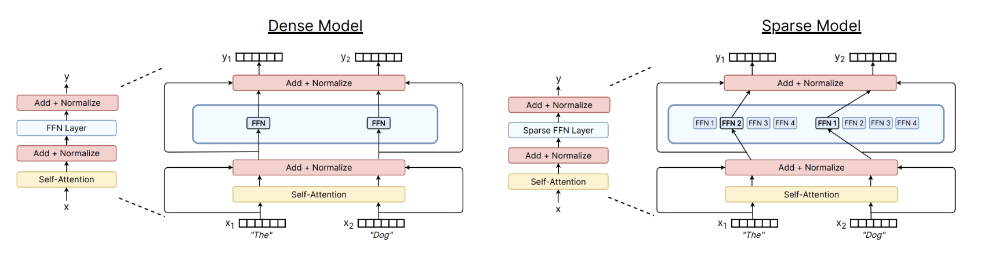

✨ [Fedus et al 2022, "Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity"](https://arxiv.org/abs/2101.03961)

✨ [CS336: Language Modeling from Scratch, Lecture 4](https://stanford-cs336.github.io/spring2025/)

Why are MoEs popular?

1. Same number of FLOPs, more parameters does better.

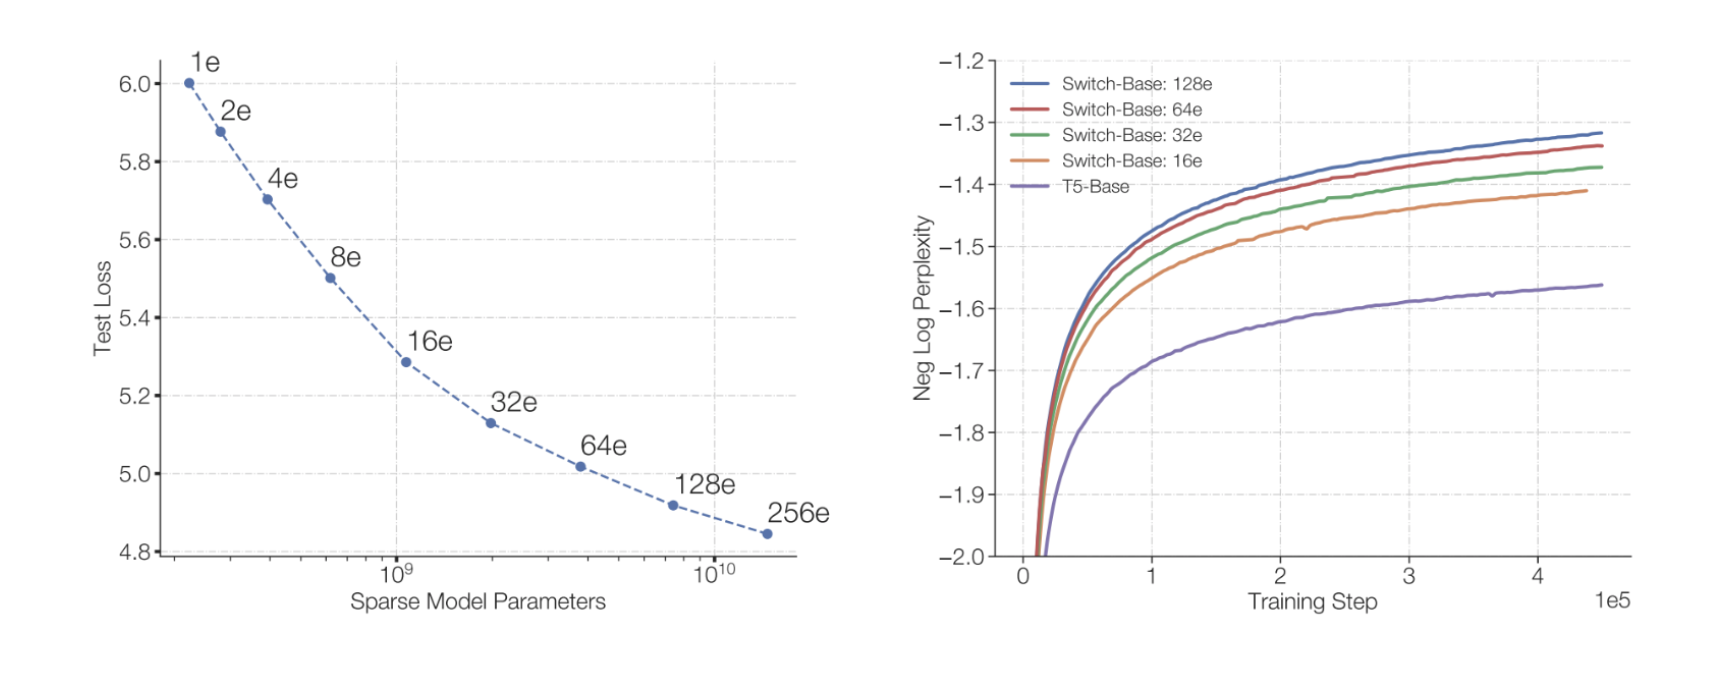

✨ [Fedus et al 2022, "Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity"](https://arxiv.org/abs/2101.03961)

2. Faster to train them.

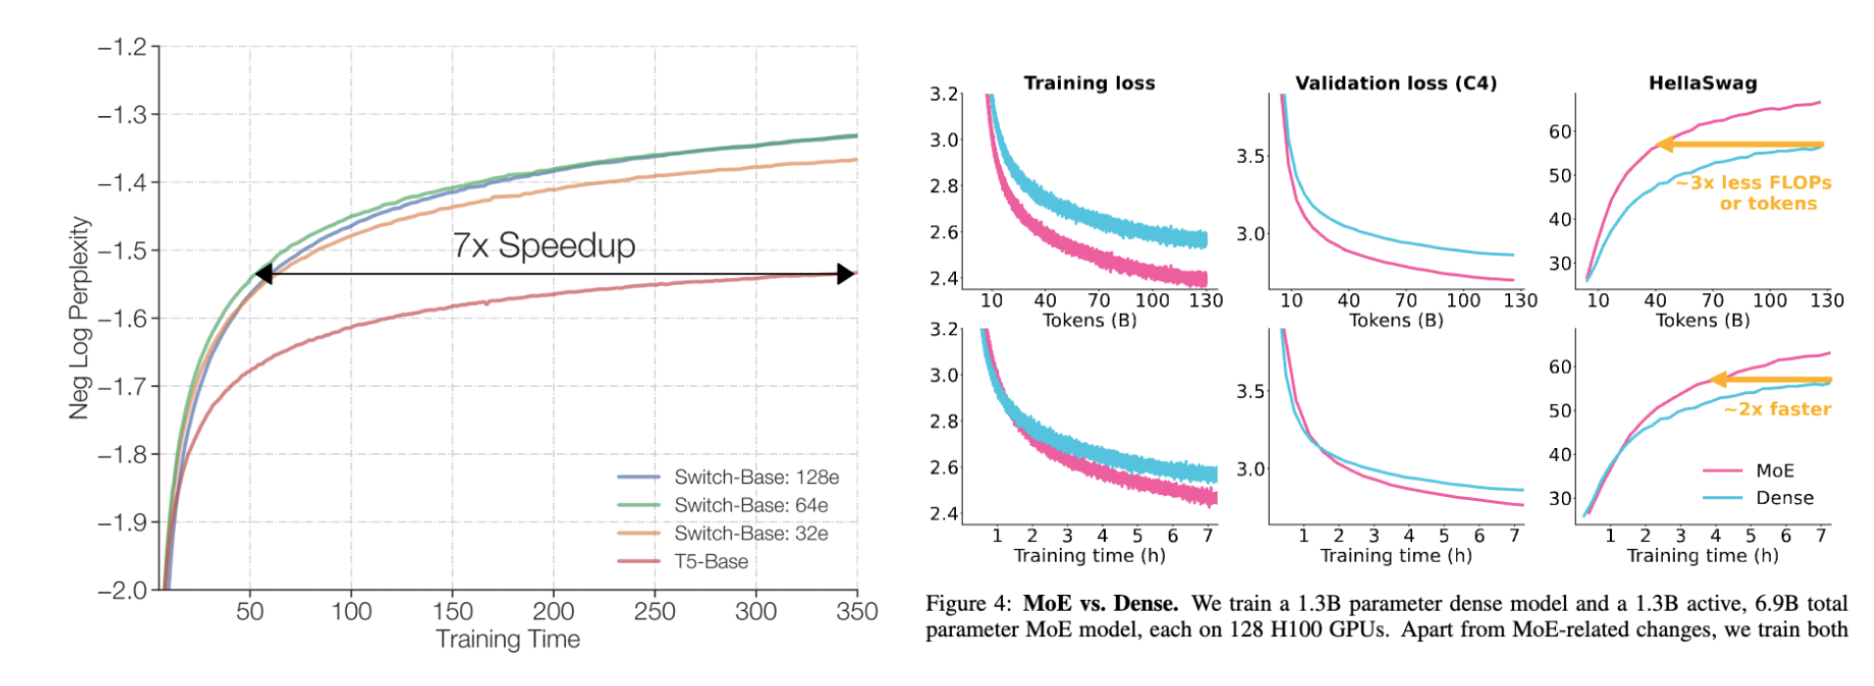

✨ [Muennighoff et al 2025, "OLMoE: Open Mixture-of-Experts Language Models"](https://arxiv.org/abs/2409.02060)

3. Parallelizable across devices

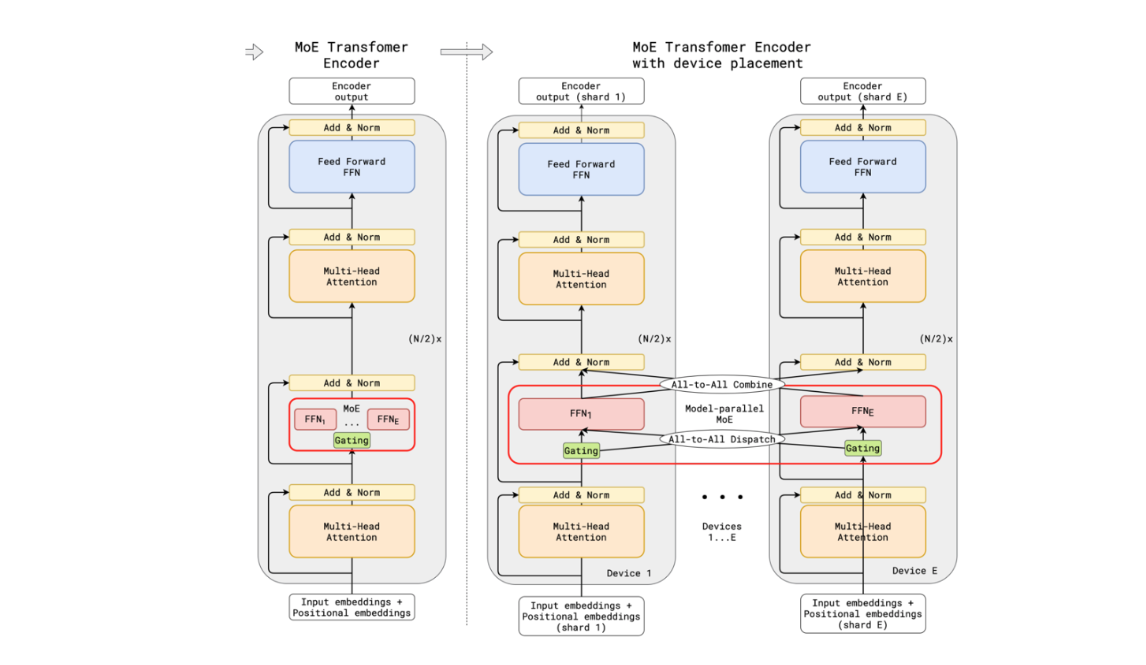

✨ [Lepikhin et al 2020, "GShard: Scaling Giant Models with Conditional Computation and Automatic Sharding"](https://arxiv.org/abs/2006.16668)

## ✍ Step 1: Expert Layer



In [ ]:
class Expert(nn.Module):
    """MLP with a single hidden layer, serving as an expert in MoE"""
    def __init__(
            self,
            d_hidden: int,
            dropout: float = 0.1,
    ):
        super().__init__()
        #######################Code Here###############################
        # Define a Linear, ReLU, Linear and Dropout, Linear should be (n_embd, 4 * n_embd)
        self.net = nn.Sequential(
            # TODO
        )
        ###############################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

## 📚 Step 2: Routing Mechanism

Types of routing in MoE systems include top-k routing (token chooses expert or expert chooses token) or global routing via optimization.
Routing is essential in MoE systems because it determines which experts to use for each input, allowing the model to specialize different experts for different types of inputs or tasks.

Noisy Top-k routing (implemented here) adds controlled randomness to the expert selection process, which can help balance expert utilization and potentially improve model performance by introducing exploration in the routing mechanism.

What's the typical choice for K? The early choice was K=2, because you want the model to “explore” a bit instead of always exploiting the top expert. That choice continues to be popular nowadays.

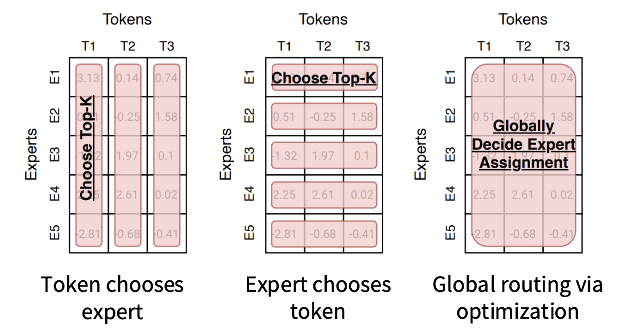




✨ [Fedus et al 2022, "Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity"](https://arxiv.org/abs/2101.03961)

In [ ]:
class NoisyTopkRouter(nn.Module):
    def __init__(
            self,
            d_hidden,
            n_experts,
            top_k_moe,
    ):
        super(NoisyTopkRouter, self).__init__()
        self.n_experts = n_experts
        # top_k_moe specifies the number of top experts to select
        self.top_k_moe = top_k_moe
        self.topkroute_linear = nn.Linear(d_hidden, n_experts)
        self.noise_linear = nn.Linear(d_hidden, n_experts)

    def forward(self, mh_output):
        # Compute logits for routing to experts
        topkroute_logits = self.topkroute_linear(mh_output)
        # Compute noise logits
        noise_logits = self.noise_linear(mh_output)
        # Generate noise with std determined by softplus of noise logits
        noise = torch.randn_like(topkroute_logits) * F.softplus(noise_logits)
        # Add noise to the original logits to get noisy logits
        noisy_topkroute_logits = topkroute_logits + noise

        # Select the top k logits and their indices from the noisy logits
        top_k_moe_logits, selected_expert_indices = noisy_topkroute_logits.topk(k=self.top_k_moe, dim=-1)

        # Create a tensor full of -inf values
        zeros = torch.full_like(noisy_topkroute_logits, float('-inf'))
        # Scatter  the top k logits into the zeros tensor to create a sparse logits tensor
        sparse_logits = zeros.scatter(-1, selected_expert_indices, top_k_moe_logits)

        # Apply softmax to the sparse logits to get the final router output
        router_output = F.softmax(sparse_logits, dim=-1)

        return router_output, selected_expert_indices

## 📚 Step 3: MoE Layer

In [ ]:
class SparseMoE(nn.Module):
    def __init__(
            self,
            d_hidden: int,
            n_experts: int,
            top_k_moe: int,
    ):
        super(SparseMoE, self).__init__()
        self.top_k_moe = top_k_moe
        self.router = NoisyTopkRouter(d_hidden, n_experts, top_k_moe)
        self.experts = nn.ModuleList([Expert(d_hidden) for _ in range(n_experts)])

    def forward(self, x):
        gating_output, expert_indices = self.router(x)

        # Flatten the input to simplify processing
        flat_x = x.view(-1, x.size(-1))
        # Flatten the gating output tensor to align with the flattened input
        flat_gating_output = gating_output.view(-1, gating_output.size(-1))

        # Initialize the final output tensor
        final_output = torch.zeros_like(x)

        # Iterate over experts
        for i, expert in enumerate(self.experts):
            # Create a mask to identify where the current expert is used
            expert_mask = (expert_indices == i).any(dim=-1)
            # Flatten the expert mask to match the flattened input
            flat_mask = expert_mask.view(-1)

            # Check if there are any positions using the current expert
            if flat_mask.any():
                expert_input = flat_x[flat_mask]
                expert_output = expert(expert_input)
                gating_scores = flat_gating_output[flat_mask, i].unsqueeze(1)
                weighted_output = expert_output * gating_scores
                final_output[expert_mask] += weighted_output.view_as(final_output[expert_mask])

        # Return the final output tensor which combines the results from all activated experts
        return final_output


## ✍ Step 4: Decoder Layer with MoE

In [ ]:
class DecoderLayerMoE(nn.Module):
    def __init__(
            self,
            d_model,
            n_heads,
            d_ff,
            n_experts,
            top_k_moe,
            dropout=0.1
    ):
        super().__init__()
        #######################Code Here###############################
        # Create the Decoder architecture as in Part 1, but now add the MoE block instead of the FFN
        # TODO
        ###############################################################

    def forward(self, x):
        #######################Code Here###############################
        # TODO
        ###############################################################
        return x

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


### ⚙️ Tweaking MoE Hyper-parameters

* Experiment: Change the number of experts in the SparseMoE_example model.
    * Observation: Observe how increasing or decreasing the number of experts affects the routing, gating outputs, and final output.

* Experiment: Adjust the top_k_moe parameter to select more or fewer top experts.
    * Observation: See how the number of experts activated for each token changes and how it impacts the final output.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseMoE_example(nn.Module):
    def __init__(
            self,
            d_hidden,
            n_experts,
            top_k_moe,
    ):
        super(SparseMoE_example, self).__init__()
        self.router = NoisyTopkRouter(d_hidden, n_experts, top_k_moe)
        self.experts = nn.ModuleList(
            [Expert(d_hidden) for _ in range(n_experts)]
        )
        self.top_k_moe = top_k_moe

    def forward(self, x):
        gating_output, expert_indices = self.router(x)
        final_output = torch.zeros_like(x)
        flat_x = x.view(-1, x.size(-1))
        flat_gating_output = gating_output.view(-1, gating_output.size(-1))

        for i, expert in enumerate(self.experts):
            expert_mask = (expert_indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)

            if flat_mask.any():
                expert_input = flat_x[flat_mask]
                expert_output = expert(expert_input)
                gating_scores = flat_gating_output[flat_mask, i].unsqueeze(1)
                weighted_output = expert_output * gating_scores
                final_output[expert_mask] += weighted_output.view_as(final_output[expert_mask])

        return final_output

    def forward_debug_example(self, x):
        # Forward pass with debug prints
        gating_output, expert_indices = self.router(x)
        print("Gating Output Shape:", gating_output.shape)
        print("Gating Output:", gating_output)
        print("Expert Indices Shape:", expert_indices.shape)
        print("Expert Indices:", expert_indices)

        print("Input Shape:", x.shape)
        print("Input:", x)

        final_output = torch.zeros_like(x)
        flat_x = x.view(-1, x.size(-1))
        flat_gating_output = gating_output.view(-1, gating_output.size(-1))

        for i, expert in enumerate(self.experts):
            print("\n" + "-"*50)
            expert_mask = (expert_indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)
            # print("Expert Index:", i)
            # print("Flat Mask Shape:", flat_mask.shape)
            # print("Flat Mask:", flat_mask)

            if flat_mask.any():
                expert_input = flat_x[flat_mask]
                print(f"Expert {i} Input Shape:", expert_input.shape)
                print(f"Expert {i} Input:", expert_input)

                expert_output = expert(expert_input)
                print(f"Expert {i} Output Shape:", expert_output.shape)
                print(f"Expert {i} Output:", expert_output)

                gating_scores = flat_gating_output[flat_mask, i].unsqueeze(1)
                print("Gating Scores Shape:", gating_scores.shape)
                print("Gating Scores:", gating_scores.squeeze())

                weighted_output = expert_output * gating_scores
                print("Weighted Output Shape:", weighted_output.shape)
                print("Weighted Output:", weighted_output)

                final_output[expert_mask] += weighted_output.view_as(final_output[expert_mask])
                print(f"Expert {i} final_output Shape:", final_output[expert_mask].shape)
                print(f"Expert {i} final_output:", final_output[expert_mask])

        print("Final MoE Output Shape:", final_output.shape)
        print("Final MoE Output:", final_output)
        print("-"*89)
        return final_output


# Example usage and debugging prints
def test_sparse_moe():
    # Parameters
    batch_size = 2
    # number of tokens, if 1 then it is easier to see which experts are
    # activated and how each embedding is calculated
    seq_length = 1
    d_hidden = 5
    # Increased number of experts
    n_experts = 6
    # If you modify top_k_moe, more or less experts will be activated for each input token
    top_k_moe = 2

    random_input = torch.randn(batch_size, seq_length, d_hidden)
    sparse_moe = SparseMoE_example(d_hidden, n_experts, top_k_moe)
    output = sparse_moe.forward_debug_example(random_input)

    print()
    print("Random Input Tensor:")
    print(random_input)
    print("Final Output Tensor:")
    print(output)

# Run the test function
test_sparse_moe()

## 📚 Step 5: Transformer with MoE

In [ ]:
class TransformerMoE(nn.Module):
    def __init__(
            self,
            vocab_size,
            d_model,
            n_heads,
            n_layers,
            d_ff,
            max_seq_length,
            dropout,
            n_experts,
            top_k_moe,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        self.layers = nn.ModuleList([
            DecoderLayerMoE(d_model, n_heads, d_ff, n_experts, top_k_moe, dropout) for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.max_seq_length = max_seq_length
        self.n_experts = n_experts
        self.top_k_moe = top_k_moe
        self.vocab_size = vocab_size

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        return self.output(x)

    def generate(
            self,
            start_tokens: torch.Tensor,
            max_length: int,
            temperature: float = 1.0,
    ) -> torch.Tensor:
        self.eval()
        current_seq = start_tokens

        with torch.no_grad():
            # Generate tokens until max_length is reached or end token is generated
            for _ in range(max_length - start_tokens.size(1)):
                # Ensure the sequence length does not exceed max_seq_length
                if current_seq.size(1) > self.max_seq_length:
                    current_seq = current_seq[:, -self.max_seq_length:]

                # Get logits from the model
                logits = self(current_seq)

                # Extact logits for the next token and scale by temperature
                next_token_logits = logits[:, -1, :] / temperature

                # Compute probabilities using softmax
                probs = F.softmax(next_token_logits, dim=-1)

                # Sample the next token from the probability distribution
                next_token = torch.multinomial(probs, num_samples=1)

                # Append the next token to the current sequence
                current_seq = torch.cat([current_seq, next_token], dim=1)

                # Stop if the end token is generated (vocab_size - 1 assumed to be the end token)
                if next_token.item() == self.vocab_size - 1:
                    break

        # Return the generated sequence
        return current_seq

In [ ]:
# @title ⚙️ Display Architecture

# Initialize the model with some example parameters
vocab_size = 10000
d_model = 512
n_heads = 2
n_layers = 1
d_ff = 2048
n_experts = 4
top_k_moe = 2
max_seq_length = 1024
dropout = 0.1

# Define your model
model_moe = TransformerMoE(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout,
    n_experts=n_experts,
    top_k_moe=top_k_moe,
)

# Print the model summary
print(50*"-")
print(summary(model_moe, input_size=(1, max_seq_length), dtypes=[torch.int64]))

In [ ]:
# @title Print model summary

def print_model_summary(model, input_size):
    model.to(device)

    dummy_input = torch.zeros(input_size, dtype=torch.int64).to(device)

    def register_hook(module):
        def hook(module, input, output):
            class_name = module.__class__.__name__
            module_idx = len(summary)
            m_key = f"{module_idx:03d} {class_name}"
            summary[m_key] = {}
            summary[m_key]["input_shape"] = list(input[0].size())
            if isinstance(output, torch.Tensor):
                summary[m_key]["output_shape"] = list(output.size())
            elif isinstance(output, (tuple, list)) and len(output) > 0 and isinstance(output[0], torch.Tensor):
                summary[m_key]["output_shape"] = [list(out.size()) for out in output]
            else:
                summary[m_key]["output_shape"] = "multiple outputs"
            params = sum(p.numel() for p in module.parameters())
            summary[m_key]["num_params"] = params

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList):
            hooks.append(module.register_forward_hook(hook))

    summary = {}
    hooks = []
    model.apply(register_hook)
    model(dummy_input)
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    print("{:>20}  {:>25} {:>15}".format("Layer (type)", "Input Shape", "Param #"))
    print("================================================================")
    total_params = 0
    total_output = 0
    for layer in summary:
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["input_shape"]),
            "{0:,}".format(summary[layer]["num_params"]),
        )
        total_params += summary[layer]["num_params"]
        if isinstance(summary[layer]["output_shape"], list) and all(isinstance(i, int) for i in summary[layer]["output_shape"]):
            total_output += np.prod(summary[layer]["output_shape"])
        print(line_new)
    print("================================================================")
    print(f"Total params: {total_params:,}")
    print("----------------------------------------------------------------")

vocab_size = 10_000
d_model = 512
n_heads = 8
n_layers = 1
d_ff = 2048
max_seq_length = 1024
dropout = 0.1
n_experts = 2
top_k_moe = 1

model_moe = TransformerMoE(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout,
    n_experts=n_experts,
    top_k_moe=top_k_moe,
)

print("\nSummary for TransformerMoE")
# Note: some input shapes might (will!) differ from run to run!
print_model_summary(model_moe, input_size=(1, max_seq_length))



## 📚 Step 6: Train MoE model

In [ ]:
import tqdm

# Load the tiny_shakespeare dataset
dataset = load_dataset('Trelis/tiny-shakespeare')['train']
texts = [sample for sample in dataset['Text']]

# Hyperparameters
d_model = 128
n_heads = 2
n_layers = 2
d_ff = 256
max_seq_length = 128
batch_size = 64
n_epochs = 10
learning_rate = 0.0001
dropout = 0.2
n_experts = 4
top_k_moe = 2

# Tokenize and prepare data
tokenizer = SimpleTokenizer()
tokenizer.fit(texts)
vocab_size = len(tokenizer.word_to_idx)

dataset_loader = TextDataset(texts, tokenizer, max_seq_length)
train_loader = DataLoader(dataset_loader, batch_size=batch_size, shuffle=True)

print(f"Vocabulary size: {vocab_size}")

# Create model
model_moe = TransformerMoE(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout,
    n_experts=n_experts,
    top_k_moe=top_k_moe,
).to(device)

# Create optimizer and loss criterion
optimizer = torch.optim.AdamW(model_moe.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx["<PAD>"])

# Training loop
for epoch in range(n_epochs):
    model_moe.train()
    total_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_seq, _, _ = batch
        input_seq = input_seq.squeeze(1).to(device)

        output = model_moe(input_seq)
        output = output[:, :-1, :].contiguous().view(-1, output.size(-1))

        target_seq = input_seq[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_seq)

        print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx == 0:
          # Debugging prints
          print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}")
          print(f"Input sequence shape: {input_seq.shape}")
          print(f"Input sequence: {input_seq.unsqueeze(1)}")
          print(f"Output shape before reshape: {output.shape}")
          print(f"Output shape after reshape: {output.shape}")
          print(f"Target sequence shape: {target_seq.shape}")

    # Print epoch loss
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(train_loader):.4f}")

### ⚙️ Evaluate MoE model

In [ ]:
texts = [
    "Better three hours too soon than",
    " I believe I can ",
    "My words fly up, my",
    "Brevity is ",
    "Love looks not with the eyes, but",
    "To be or ",
]

for quote in texts:
    start_tokens = torch.tensor(tokenizer.encode(quote)).unsqueeze(0).to(device)

    generated_tokens = model_moe.generate(start_tokens, max_length=20, temperature=.9)
    generated_text = tokenizer.decode(generated_tokens.squeeze().tolist())

    print(generated_text)

# Architecture Optimizations

The key to the MultiHeadAttention mechanism is the softmax attention.
The attention scores are computed using the scaled dot-product of the Query and Key vectors:

$$
\text{Attention}(Q, K, V) =
\text{softmax}
    \Big(
        \frac{QK^T}{\sqrt{d_k}}
    \Big)
    V
$$

where:
+ $Q, K, V$ are the "query", "key" and "value" vectors respectively. These are typically linear projections of the same tensor (through different weights).
+ $d_k$ is the dimensionality of the $Q, K, V$ vectors. In the case of a "multi-head" attention, this correponds to dimensionality of a single "head" vector ($d_{head}$).
+ The `softmax` operation ensures that the scores are normalized and mapped through a non-linearity, which increases NN's expressivity (side note: there exist [Transfomer version with Linear Attention](https://arxiv.org/abs/2006.16236), that are faster, but also less powerful).
+ $\sqrt{d_k}$ is the scaling factor that helps mitigate the issue of large dot-product values.


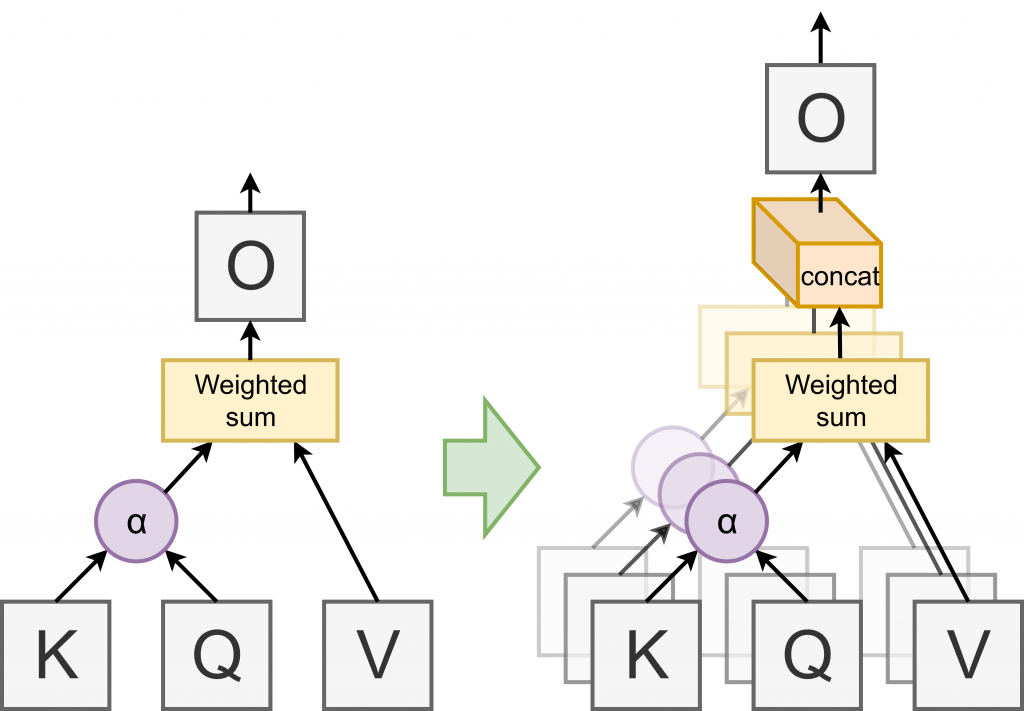

Reference: [Are Sixteen Heads Really Better than One?
](https://blog.ml.cmu.edu/2020/03/20/are-sixteen-heads-really-better-than-one/)

Transformers have quadratic computation complexity with respect to the sequence length and their inference is typically memory-limited.

The big bottleneck is the so-called "KV cache" (more about this below). Thus we resort to optimizations such as reducing the KV cache size, quantization, architecture optimizations etc. The less memory your computation takes, the faster you go.

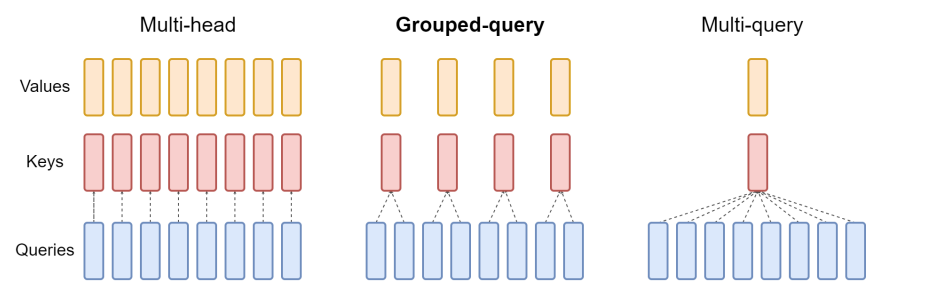

✨ [GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints](https://arxiv.org/abs/2305.13245)

Idea: N query heads, but only K key and value heads, each interacting with N/K query heads.
1. Multi-headed attention (MHA): K=N
2. Multi-query attention (MQA): K=1.
3. Group-query attention (GQA): K is somewhere between 1 and N.

=> Reduce the KV cache by a factor of N/K.

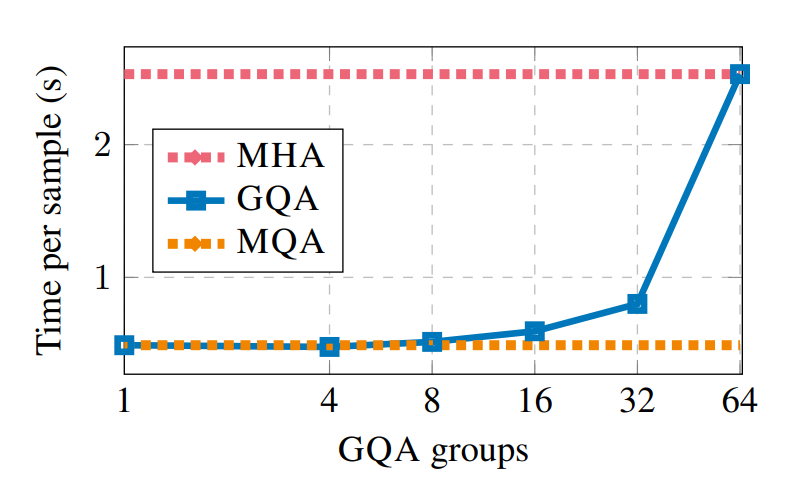


✨ [GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints](https://arxiv.org/abs/2305.13245)

## ✍ Step 1: Multi-head Attention (MHA)

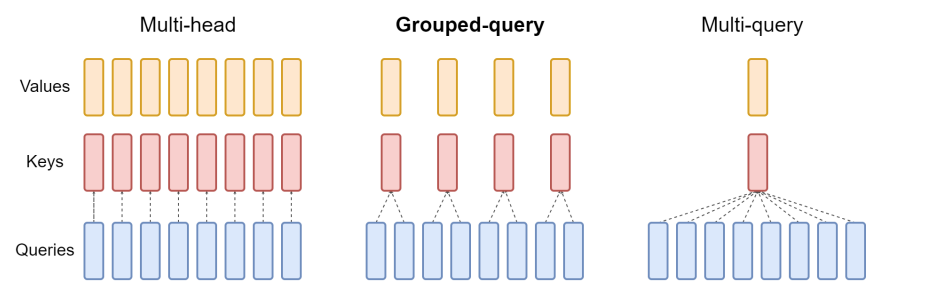

✨ [GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints](https://arxiv.org/abs/2305.13245)

In [ ]:
# Multi-head Attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # EXERCISE: create the following 4 linear layers
        self.linear_q = TODO
        self.linear_k = TODO
        self.linear_v = TODO
        self.linear_out = TODO

    def forward(self, query, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.linear_q(query)
        K = self.linear_k(query)
        V = self.linear_v(query)

        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)
        K = K.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)
        V = V.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, n_heads, seq_len, seq_len)

        # EXERCISE: divide the scores by the normalizing factor
        scores = TODO

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)

        # Attention weights
        # EXERCISE: apply the softmax to the scores to have the attn_weights
        attn_weights = TODO

        # Weighted sum of values
        attn_output = torch.matmul(attn_weights, V)  # (batch_size, n_heads, seq_len, d_head)

        # Concatenate heads and project back to d_model
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)
        attn_output = self.linear_out(attn_output)  # (batch_size, seq_len, d_model)

        return attn_output


## ✍ Step 2: MQA: Multi-query Attention

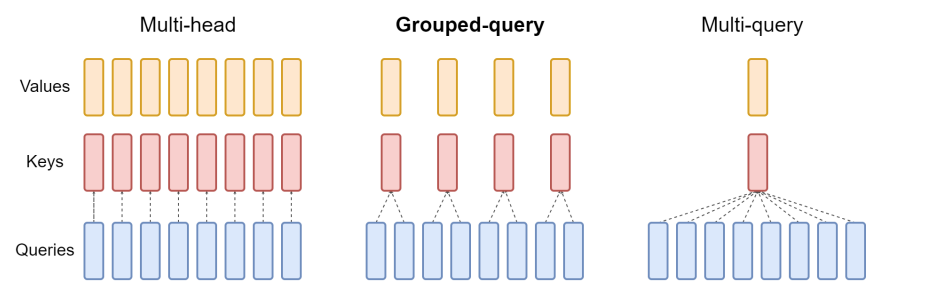

✨ [GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints](https://arxiv.org/abs/2305.13245)

In [ ]:
class MultiQueryAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiQueryAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # EXERCISE: create the following 4 linear layers
        self.linear_q = TODO
        self.linear_k = TODO
        self.linear_v = TODO
        self.linear_out = TODO

    def forward(self, query, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.linear_q(query)
        K = self.linear_k(query)
        V = self.linear_v(query)

        # Split Q into multiple heads
        Q = Q.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)
        # K and V are not split into heads, but expanded
        K = K.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # (batch_size, n_heads, seq_len, d_head)
        V = V.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # (batch_size, n_heads, seq_len, d_head)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / np.sqrt(self.d_head)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        # Attention weights
        attn_weights = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        attn_output = torch.matmul(attn_weights, V)

        # Concatenate heads and project back to d_model
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        attn_output = self.linear_out(attn_output)

        return attn_output



## ✍ Step 3: GQA: Group-Query Attention

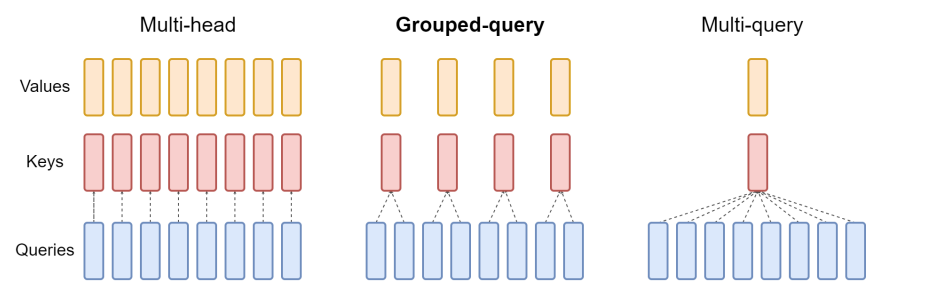

✨ [GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints](https://arxiv.org/abs/2305.13245)

In [ ]:
class GroupQueryAttention(nn.Module):
    def __init__(self, d_model, n_heads, n_kv_heads):
        super(GroupQueryAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        assert n_heads % n_kv_heads == 0, "n_heads must be divisible by n_kv_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.d_head = d_model // n_heads
        # EXERCISE: set n_groups based on n_heads and n_kv_heads
        self.n_groups = TODO

        # EXERCISE: create the following 4 linear layers
        self.linear_q = TODO
        self.linear_k = TODO
        self.linear_v = TODO
        self.linear_out = TODO

    def forward(self, query, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)

        # Linear projections
        Q = self.linear_q(query)
        K = self.linear_k(query)
        V = self.linear_v(query)

        # EXERCISE: Split into multiple heads
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_kv_heads, self.d_head).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_kv_heads, self.d_head).transpose(1, 2)


        # Repeat K and V for each group
        K = K.unsqueeze(2).repeat(1, 1, self.n_groups, 1, 1).view(batch_size, self.n_heads, seq_len, self.d_head)
        V = V.unsqueeze(2).repeat(1, 1, self.n_groups, 1, 1).view(batch_size, self.n_heads, seq_len, self.d_head)


        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / np.sqrt(self.d_head)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        # Attention weights
        attn_weights = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        attn_output = torch.matmul(attn_weights, V)

        # Concatenate heads and project back to d_model
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        attn_output = self.linear_out(attn_output)

        return attn_output


## ✍ Step 4: MHA with KV cache

Naive inference:

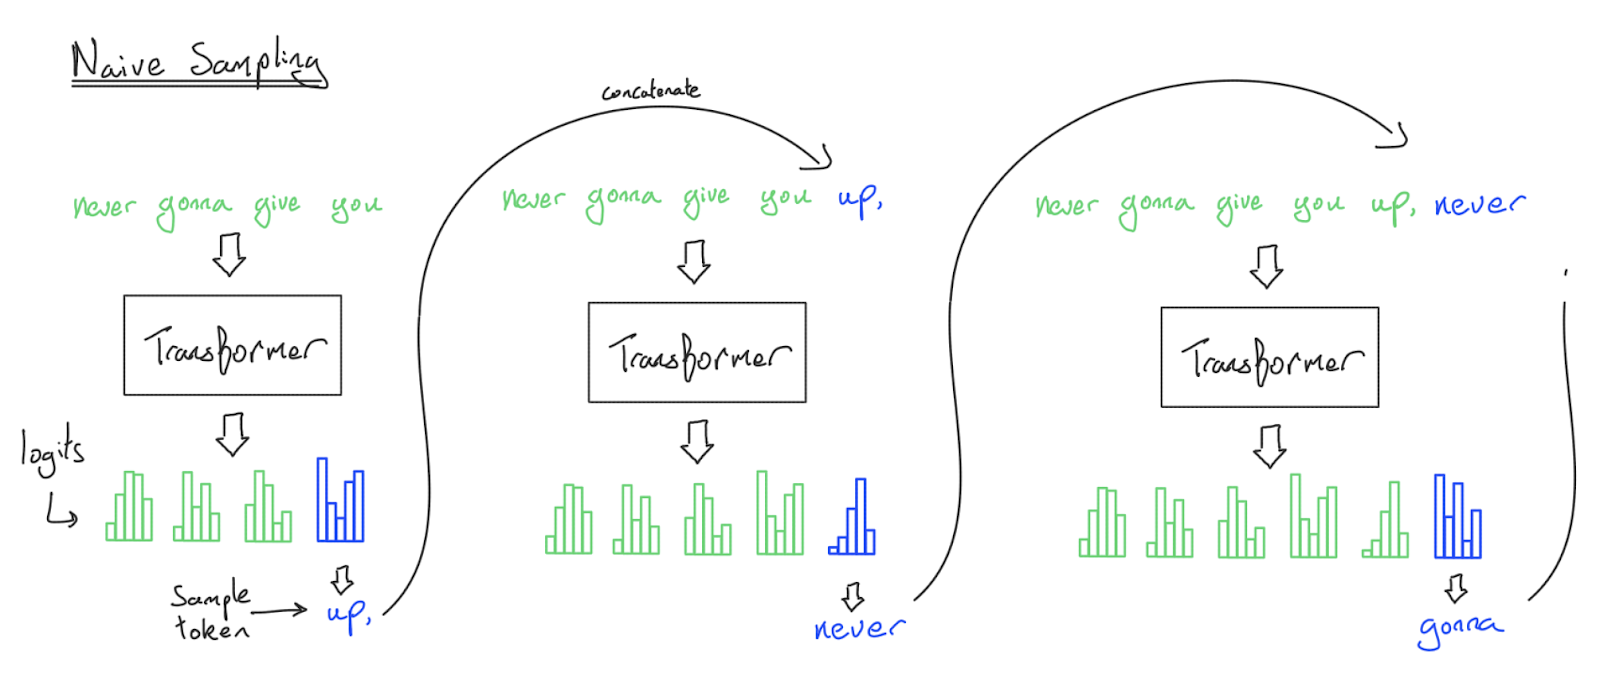

✨ [Scaling book: Inference](https://jax-ml.github.io/scaling-book/inference/)

Naive inference:

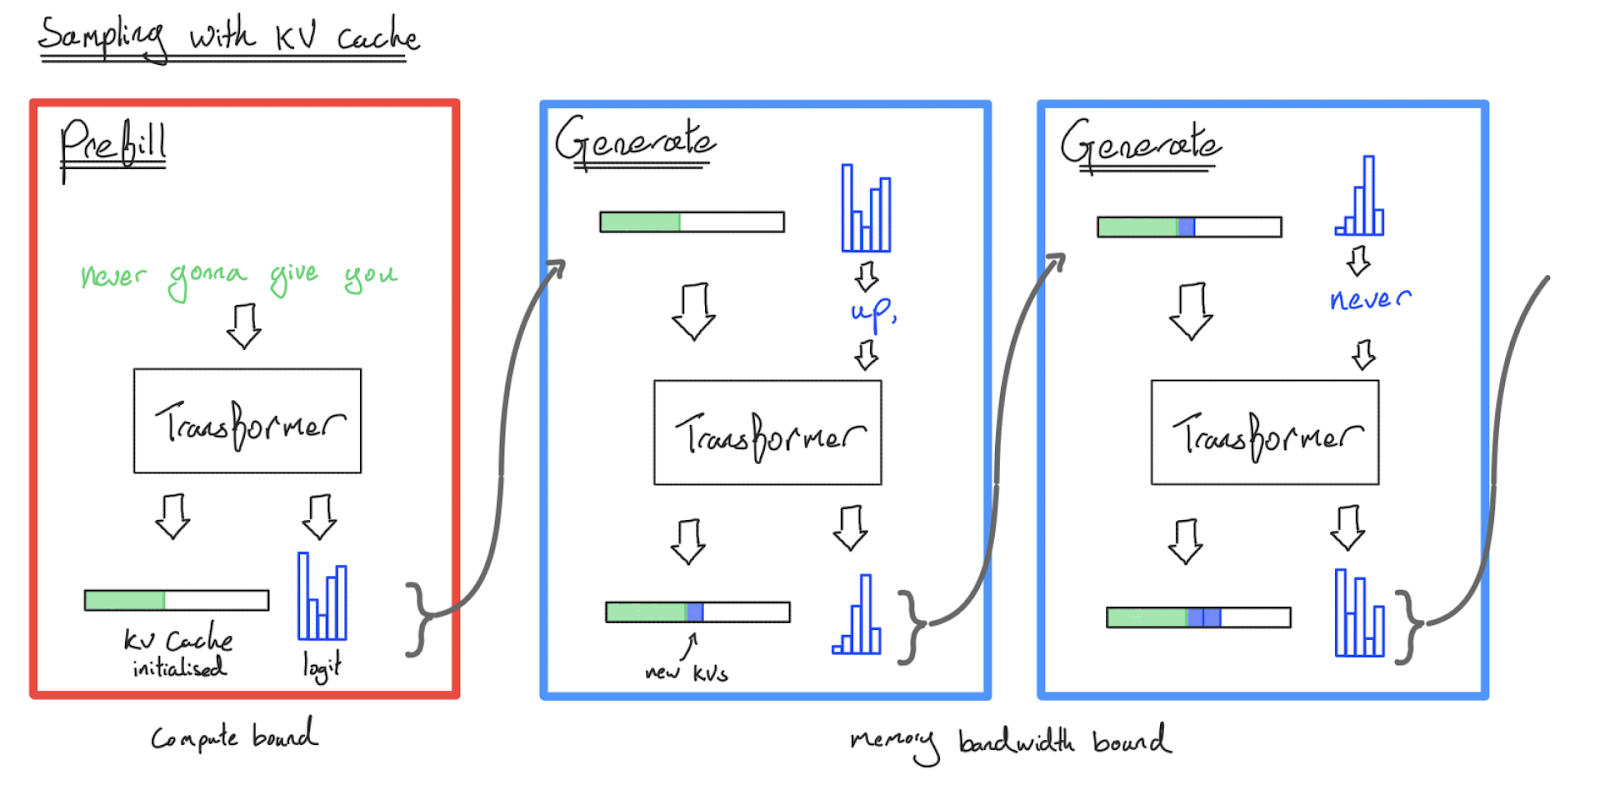

✨ [Scaling book: Inference](https://jax-ml.github.io/scaling-book/inference/)

KV cache: for every sequence (B), token (S), layer (L), head (K), store an H-dimensional vector

Two stages of inference:
1. Prefill: given a prompt, encode into vectors (parallelizable like in training)
2. Generation: generate new response tokens (sequential)


In [ ]:
class MultiHeadAttentionWithCache(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttentionWithCache, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.linear_q = nn.Linear(d_model, d_model, bias=False)
        self.linear_k = nn.Linear(d_model, d_model, bias=False)
        self.linear_v = nn.Linear(d_model, d_model, bias=False)
        self.linear_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, query, cache=None, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.linear_q(query)
        K = self.linear_k(query)
        V = self.linear_v(query)

        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)

        if cache is not None:
            past_K, past_V = cache
            K = torch.cat([past_K, K], dim=2)
            V = torch.cat([past_V, V], dim=2)

        new_cache = (K, V)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / np.sqrt(self.d_head)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        # Attention weights
        attn_weights = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        attn_output = torch.matmul(attn_weights, V)

        # Concatenate heads and project back to d_model
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        attn_output = self.linear_out(attn_output)

        return attn_output, new_cache

## ⚙️ Step 5: Compare Attention Variants

In [ ]:
import time

def evaluate_attention_speed(model, input_tensor, iterations=100):
    """Measures the average forward pass time for a given model."""
    model.to(device)
    input_tensor = input_tensor.to(device)
    model.eval()

    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(input_tensor)
    end_time = time.time()
    return (end_time - start_time) / iterations

def evaluate_attention_speed_with_cache(model, input_tensor, iterations=100):
    """Measures the average forward pass time for a model with a KV cache during inference."""
    model.to(device)
    input_tensor = input_tensor.to(device)
    model.eval()

    # Populate cache
    cache = None
    with torch.no_grad():
      for i in range(input_tensor.size(1) - 1):
          _, cache = model(input_tensor[:, i:i+1, :], cache=cache)

    # Measure time for the last token
    last_token_input = input_tensor[:, -1:, :]

    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _, _ = model(last_token_input, cache=cache)

    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _, _ = model(last_token_input, cache=cache)
    end_time = time.time()
    return (end_time - start_time) / iterations


def run_speed_evaluation():
    d_model = 512
    n_heads = 64
    n_kv_heads = 16
    batch_size = 16
    seq_length = 512
    iterations = 50

    # Create dummy input tensor
    input_tensor = torch.randn(batch_size, seq_length, d_model)

    # Instantiate models
    mha = MultiHeadAttention(d_model, n_heads)
    mqa = MultiQueryAttention(d_model, n_heads)
    gqa = GroupQueryAttention(d_model, n_heads, n_kv_heads)
    mha_cache = MultiHeadAttentionWithCache(d_model, n_heads)


    print("--- Attention Speed Evaluation (without KV cache) ---")
    mha_time = evaluate_attention_speed(mha, input_tensor, iterations)
    print(f"Multi-Head Attention: {mha_time:.6f} seconds per forward pass")

    mqa_time = evaluate_attention_speed(mqa, input_tensor, iterations)
    print(f"Multi-Query Attention: {mqa_time:.6f} seconds per forward pass")

    gqa_time = evaluate_attention_speed(gqa, input_tensor, iterations)
    print(f"Group-Query Attention: {gqa_time:.6f} seconds per forward pass")

    print("--- Attention Speed Evaluation (with KV cache) ---")
    mha_cache_time = evaluate_attention_speed_with_cache(mha_cache, input_tensor, iterations)
    print(f"Multi-Head Attention with Cache: {mha_cache_time:.6f} seconds per token")

run_speed_evaluation()



# Speculative Decoding

Recall the two stages of inference:
1. Prefill: given a sequence, encode tokens in parallel (compute-limited) [note: also gives you probabilities]
2. Generation: generate one token at a time (memory-limited)

=> checking is faster than generation.


Main idea for speculative decoding:
1. Use a cheaper draft model P to guess a few tokens (e.g. 4)
2. Evaluate with the target model q(process tokens in parallel) and accept if it looks good.

✨ [Fast Inference from Transformers via Speculative Decoding](https://arxiv.org/abs/2211.17192)

✨ [Accelerating Large Language Model Decoding with Speculative Sampling](https://arxiv.org/abs/2302.01318)


In [ ]:
!gdown --id 1uL5rytZKnNLsMCj_FAsPB5eWEso5SN7E -O video.mp4
from IPython.display import Video
Video('video.mp4', embed=True)

In [ ]:
# @title 📚 Define a larger MoE model

# Original MoE model (trained above)
# d_model = 128
# n_heads = 2
# n_layers = 2
# d_ff = 256

# Example of a larger model
large_d_model = 256
large_n_heads = 4
large_n_layers = 5
large_d_ff = 1024


large_model_moe = TransformerMoE(
    vocab_size=vocab_size,
    d_model=large_d_model,
    n_heads=large_n_heads,
    n_layers=large_n_layers,
    d_ff=large_d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout,
    n_experts=n_experts,
    top_k_moe=top_k_moe,
).to(device)


In [ ]:
# @title 📚 Train the large model

# Load the tiny_shakespeare dataset
dataset = load_dataset('Trelis/tiny-shakespeare')['train']
texts = [sample for sample in dataset['Text']]

dataset_loader = TextDataset(texts, tokenizer, max_seq_length)
train_loader = DataLoader(dataset_loader, batch_size=batch_size, shuffle=True)

# Create optimizer and loss criterion
optimizer = torch.optim.AdamW(large_model_moe.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx["<PAD>"])

# Training loop
for epoch in range(n_epochs):
    large_model_moe.train()
    total_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_seq, _, _ = batch
        input_seq = input_seq.squeeze(1).to(device)

        output = large_model_moe(input_seq)
        output = output[:, :-1, :].contiguous().view(-1, output.size(-1))

        target_seq = input_seq[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_seq)

        print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx == 0:
          # Debugging prints
          print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}")
          print(f"Input sequence shape: {input_seq.shape}")
          print(f"Input sequence: {input_seq.unsqueeze(1)}")
          print(f"Output shape before reshape: {output.shape}")
          print(f"Output shape after reshape: {output.shape}")
          print(f"Target sequence shape: {target_seq.shape}")

    # Print epoch loss
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(train_loader):.4f}")

In [ ]:
# @title 📚 Define Speculative Decoding

def speculative_decode(target_model, drafter_model, start_tokens, max_length, gamma, temperature=1.0):
    """
    Generates text using speculative decoding.

    Args:
        target_model: The larger, accurate model.
        drafter_model: The smaller, faster model.
        start_tokens: Initial sequence of tokens.
        max_length: Maximum length of the generated sequence.
        gamma: The number of tokens the drafter model predicts ahead.
        temperature: Temperature for sampling.

    Returns:
        The generated sequence.
    """
    target_model.eval()
    drafter_model.eval()
    current_seq = start_tokens

    with torch.no_grad():
        while current_seq.size(1) < max_length:
            # 1. Draft gamma tokens using the drafter model
            draft_seq = current_seq
            for _ in range(gamma):
                if draft_seq.size(1) >= max_length:
                    break
                logits = drafter_model(draft_seq[:, -target_model.max_seq_length:])
                next_token_logits = logits[:, -1, :] / temperature
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                draft_seq = torch.cat([draft_seq, next_token], dim=1)

            if draft_seq.size(1) == current_seq.size(1):
                break # No new tokens drafted

            drafted_tokens = draft_seq[:, current_seq.size(1):]

            # 2. Verify the drafted tokens with the target model
            target_logits = target_model(draft_seq[:, -target_model.max_seq_length:])
            target_logits = target_logits[:, current_seq.size(1)-1:-1, :] / temperature
            target_probs = F.softmax(target_logits, dim=-1)

            accepted_count = 0
            for i in range(drafted_tokens.size(1)):
                token = drafted_tokens[:, i]
                target_dist = target_probs[:, i, :]

                # Simple acceptance criteria: Check if the drafted token is the most likely
                # according to the target model. More sophisticated methods can be used.
                if torch.argmax(target_dist, dim=-1) == token:
                    current_seq = torch.cat([current_seq, token.unsqueeze(1)], dim=1)
                    accepted_count += 1
                else:
                    # Reject and sample from the target model's distribution for the current position
                    # Corrective sample
                    probs = F.softmax(target_logits[:, i, :], dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                    current_seq = torch.cat([current_seq, next_token], dim=1)
                    break # Stop verifying further if a token is rejected
            print(f'Number of accepted draft tokens {accepted_count}/{drafted_tokens.size(1)}',)

            # If all drafted tokens were accepted, sample one more from the last target distribution
            if accepted_count == drafted_tokens.size(1) and current_seq.size(1) < max_length:
                 last_logits = target_model(current_seq[:, -target_model.max_seq_length:])[:, -1, :] / temperature
                 probs = F.softmax(last_logits, dim=-1)
                 next_token = torch.multinomial(probs, num_samples=1)
                 current_seq = torch.cat([current_seq, next_token], dim=1)

            if current_seq.size(1) >= max_length:
                break
            if current_seq[:, -1].item() == target_model.vocab_size - 1: # Assuming vocab_size - 1 is EOS
                break

    return current_seq


In [ ]:
# @title 📚 Evaluate Speculative Decoding

import time

batch_size = 1 # Speculative decoding is often used with batch size 1
seq_length = 50
max_gen_length = 50
gamma = 5 # Number of tokens to draft
n_iterations = 4
temperature = 0.1

start_text = "To be or not to"
start_tokens = torch.tensor(tokenizer.encode(start_text)).unsqueeze(0).to(device)
if start_tokens.size(1) > max_seq_length:
    start_tokens = start_tokens[:, :max_seq_length]

# Target model (using the larger MoE model)
target_model = large_model_moe
drafter_model_moe = model_moe

print(f"\n--- Speculative Decoding Evaluation (gamma={gamma}) ---")

# Standard Generation Speed
st = time.time()
for i in range(n_iterations):
    print(f"Standard generation iteration: {i+1}/{n_iterations}")
    _ = target_model.generate(start_tokens, max_gen_length, temperature=temperature)
et = time.time()
normal_gen_time = (et - st) / n_iterations
print(f"Standard generate() time: {normal_gen_time:.4f} seconds")

# Speculative Decoding Speed
st = time.time()
for i in range(n_iterations):
    print(f"Speculative Decoding iteration: {i+1}/{n_iterations}")
    _ = speculative_decode(target_model, drafter_model_moe, start_tokens, max_gen_length, gamma=gamma, temperature=temperature)
et = time.time()
speculative_gen_time = (et - st) / n_iterations
print(f"Speculative decode() time: {speculative_gen_time:.4f} seconds")

speedup = normal_gen_time / speculative_gen_time
print(f"Estimated Speedup: {speedup:.2f}x.")
print("Note: it is ok if you do not observe a speed up. \
This can happen if the models are not 'optimized' well enough, so they do not model the same distribution!")




# Congratulations!

    \o/   🎉
     |       CONGRATS!
    / \      You did it 🎓 You are done with the second part of the tutorial.

